In [1]:
import sys
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import Image
from six.moves import range
from __future__ import print_function
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_labels']
    test_dataset = save['test_data']
    test_labels = save['test_labels']
    test_filenames = save['test_filenames']
    valid_dataset = save['valid_data']
    valid_labels = save['valid_labels']
    del save
    
    print('Training dataset', train_dataset.shape, train_labels.shape)
    print('Validation dataset', valid_dataset.shape, valid_labels.shape)
    print('Test dataset', test_dataset.shape, test_labels.shape)

Training dataset (83401, 32, 32, 1) (83401, 6)
Validation dataset (152353, 32, 32, 1) (152353, 6)
Test dataset (13068, 32, 32, 1) (13068, 6)


Here's some random sample images we'll try to predict using the conv net model:


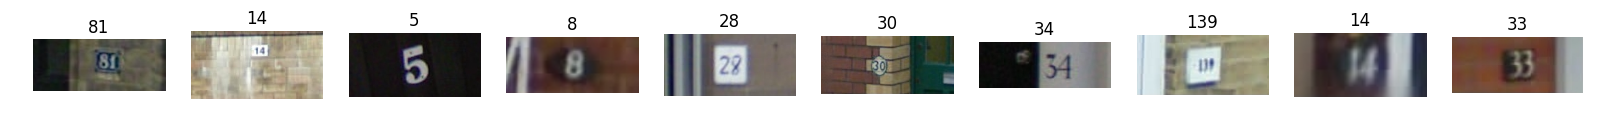

In [3]:
from PIL import Image

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

print("Here's some random sample images we'll try to predict using the conv net model:")

im_samples = []
for i, item in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = test_filenames[item]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[item,0]):
        house_num += str(test_labels[item,k+1])
        
    im_samples.extend([item])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [4]:
def gauss_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization (LCN): is inspired by computational neuroscience models.
    """   

    # Implement a Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gauss_filter(filter_shape), borrow=True)
    filters = gauss_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        square_sum_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denominator = tf.sqrt(square_sum_XX)

        per_img_mean = tf.reduce_mean(denominator)
        divisor = tf.maximum(per_img_mean, denominator)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X
    return new_X

In [5]:
## Recover the Conv Net Arch & Test Results of the Model

size_of_image = 32
number_of_labels = 11 ## 0-9 & blank 
number_of_channels = 1 ## grayscale
size_of_train = train_labels.shape[0]

batch_size = 64
patch_size = 5
depth_a = 32
depth_b = 64
depth_c = 128
hidden_number1 = 512
hidden_number2 = 128
hidden_number3 = 32
shape = [batch_size, size_of_image, size_of_image, number_of_channels]

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))

    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w1 = tf.get_variable("WS11", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS11')
    
    s2_w1 = tf.get_variable("WS12", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS12')
    
    s3_w1 = tf.get_variable("WS13", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS13')
    
    s4_w1 = tf.get_variable("WS14", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS14')
    
    s5_w1 = tf.get_variable("WS15", shape=[num_hidden1, num_hidden2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b1 = tf.Variable(tf.constant(1.0, shape=[num_hidden2]), name='BS15')    

    s1_w2 = tf.get_variable("WS21", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS21')
    
    s2_w2 = tf.get_variable("WS22", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS22')
    
    s3_w2 = tf.get_variable("WS23", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS23')
    
    s4_w2 = tf.get_variable("WS24", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS24')
    
    s5_w2 = tf.get_variable("WS25", shape=[num_hidden2, num_hidden3],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b2 = tf.Variable(tf.constant(1.0, shape=[num_hidden3]), name='BS25')    

    s1_w3 = tf.get_variable("WS31", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS31')
    
    s2_w3 = tf.get_variable("WS32", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS32')
    
    s3_w3 = tf.get_variable("WS33", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS33')
    
    s4_w3 = tf.get_variable("WS34", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS34')
    
    s5_w3 = tf.get_variable("WS35", shape=[num_hidden3, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b3 = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS35')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        # hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        hidden11 = tf.nn.relu(tf.matmul(reshape, s1_w1) + s1_b1)
        hidden21 = tf.nn.relu(tf.matmul(reshape, s2_w1) + s2_b1)
        hidden31 = tf.nn.relu(tf.matmul(reshape, s3_w1) + s3_b1)
        hidden41 = tf.nn.relu(tf.matmul(reshape, s4_w1) + s4_b1)
        hidden51 = tf.nn.relu(tf.matmul(reshape, s5_w1) + s5_b1)
        
        hidden12 = tf.nn.relu(tf.matmul(hidden11, s1_w2) + s1_b2)
        hidden22 = tf.nn.relu(tf.matmul(hidden21, s2_w2) + s2_b2)
        hidden32 = tf.nn.relu(tf.matmul(hidden31, s3_w2) + s3_b2)
        hidden42 = tf.nn.relu(tf.matmul(hidden41, s4_w2) + s4_b2)
        hidden52 = tf.nn.relu(tf.matmul(hidden51, s5_w2) + s5_b2)
        
        logits1 = tf.matmul(hidden12, s1_w3) + s1_b3
        logits2 = tf.matmul(hidden22, s2_w3) + s2_b3
        logits3 = tf.matmul(hidden32, s3_w3) + s3_b3
        logits4 = tf.matmul(hidden42, s4_w3) + s4_b3
        logits5 = tf.matmul(hidden52, s5_w3) + s5_b3
        
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_test_dataset, 1, shape)

    predict = tf.pack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                       tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
    test_prediction = tf.transpose(tf.argmax(predict, 2))
    saver = tf.train.Saver()

In [6]:
with tf.Session(graph=graph) as session:
    saver.restore(session, "cnn.convnet")
    print("Conv Net Model has been Restored!\n")  

    print('Initializing Prediction of Test Results (using the Conv Net model restored above)...\n')
    test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    print('Prediction Completed Successfully!\n')
    
    print('Matrix of Predicted Results:\n')
    print(test_prediction)

Conv Net Model has been Restored!

Initializing Prediction of Test Results (using the Conv Net model restored above)...

Prediction Completed Successfully!

Matrix of Predicted Results:

[[ 8  1 10 10 10]
 [ 1  4 10 10 10]
 [ 5 10 10 10 10]
 [ 8 10 10 10 10]
 [ 2  2 10 10 10]
 [ 3  0 10 10 10]
 [ 3  4 10 10 10]
 [ 1  3  1 10 10]
 [ 1  4 10 10 10]
 [ 3  3 10 10 10]]


The Predicted vs Actual Image Labes: 



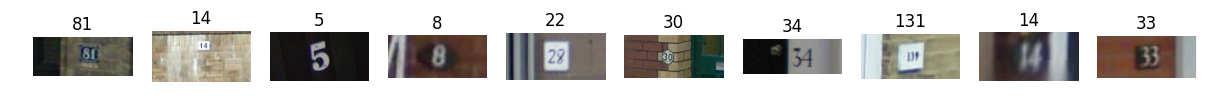

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

print("The Predicted vs Actual Image Labes: \n")

for i, j in enumerate(im_samples):
    filename = test_filenames[j]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)